In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import time
import PIL
from IPython import display

2023-01-13 09:32:39.239435: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [3]:
def discriminator_model():
    model = tf.keras.Sequential()

    model.add(layers.Conv2D(32, (5, 5), activation = "relu", strides = (2, 2), padding = 'same', input_shape = [28, 28, 1]))
    model.add(layers.MaxPooling2D(2, 2))
    model.add(layers.BatchNormalization(axis = -1))

    model.add(layers.Conv2D(64, (5, 5), activation = "relu", strides = (2, 2), padding = 'same'))
    model.add(layers.MaxPooling2D(2, 2))
    model.add(layers.BatchNormalization(axis = -1))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [4]:
def generator_model():
    model = tf.keras.Sequential()

    model.add(layers.Dense(7 * 7 * 256, use_bias=False, input_shape=(100, )))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')) # I think tanh is used to get to (-1, 1) format for greyscale

    return model


In [5]:
generator = generator_model()
discriminator = discriminator_model()
general_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

2023-01-13 09:32:44.646535: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
def discriminator_loss(real_output, fake_output):
    real_loss = general_loss(tf.ones_like(real_output), real_output)
    fake_loss = general_loss(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [7]:
def generator_loss(fake_output):
    return general_loss(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [8]:
EPOCHS = 10
BUFFER_SIZE = 60000
BATCH_SIZE = 256
noise_dimension = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dimension])
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [9]:
@tf.function # annontation causes the function to be compiled
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dimension])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [10]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('images/image_at_epoch_{:04d}.png'.format(epoch))
  #plt.show()

In [11]:
def train(dataset, start_epoch, end_epoch):
    for epoch in range(start_epoch, end_epoch):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)
        
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch+1, seed)
        
        print(f"Time for epoch {epoch + 1} is {time.time()-start}")

    display.clear_output(wait=True)
    generate_and_save_images(generator, end_epoch, seed)

Time for epoch 50 is 258.7386620044708


KeyboardInterrupt: 

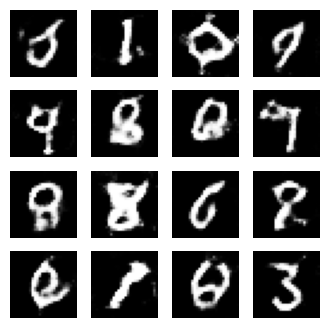

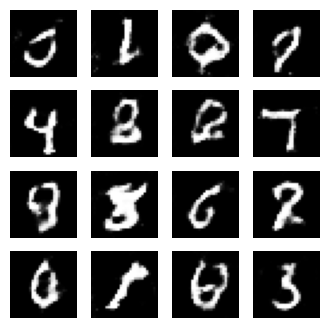

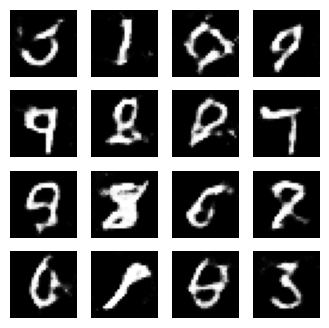

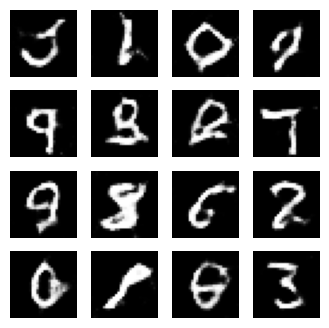

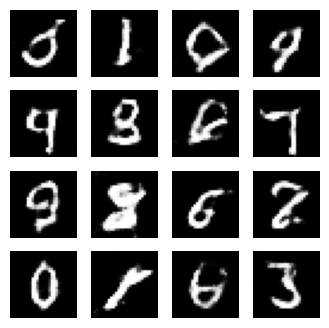

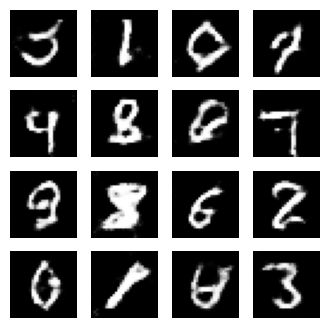

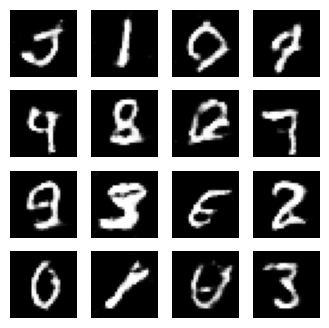

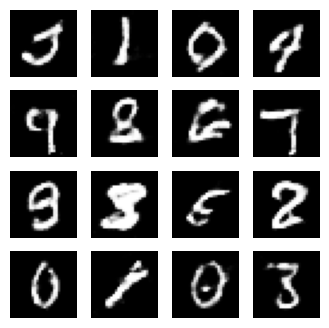

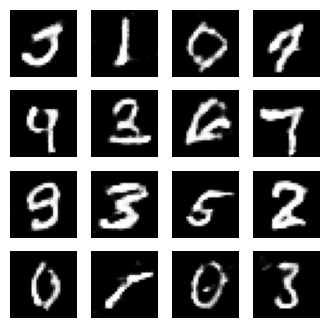

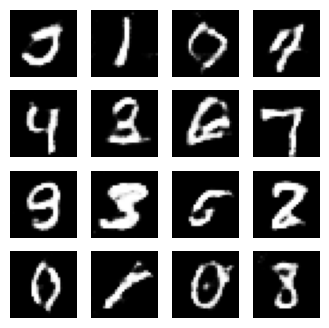

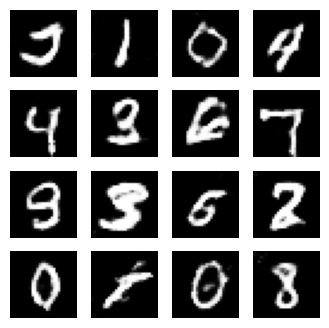

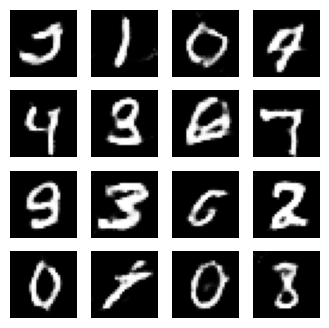

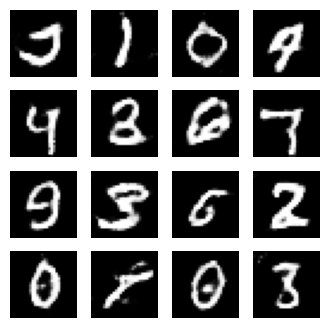

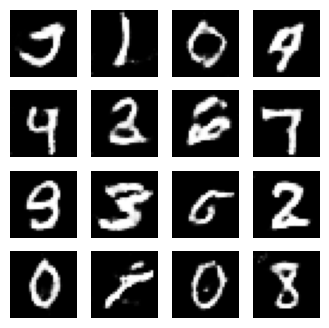

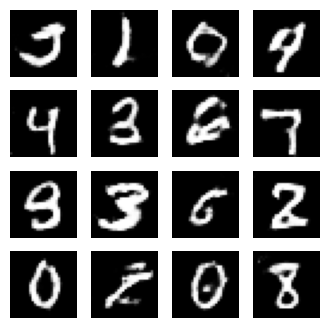

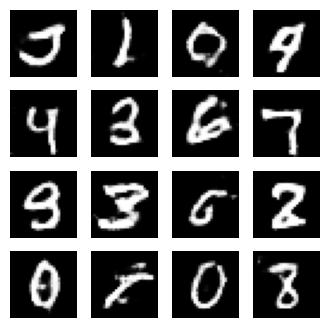

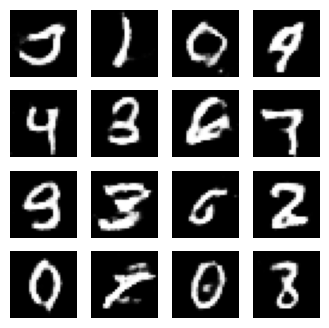

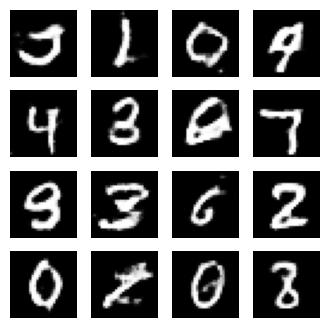

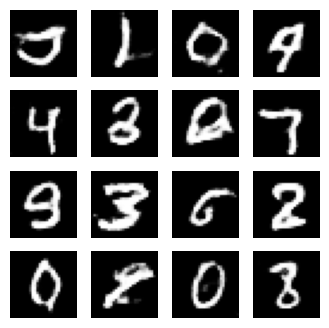

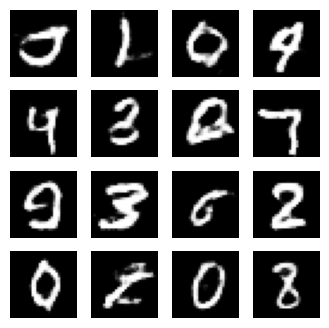

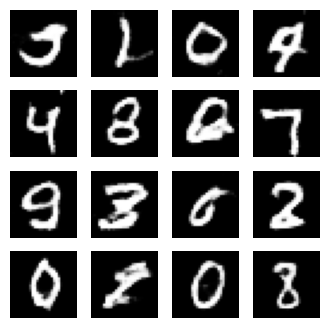

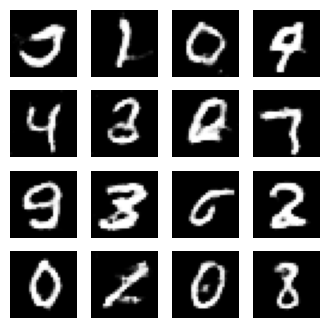

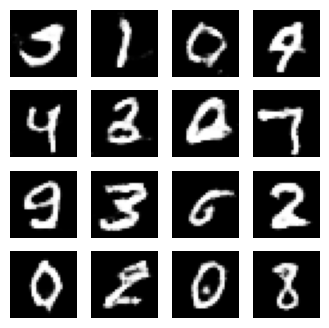

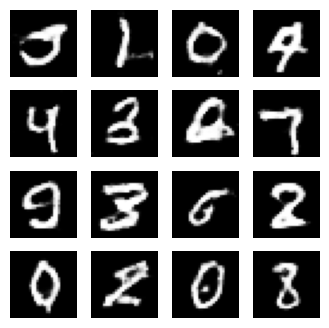

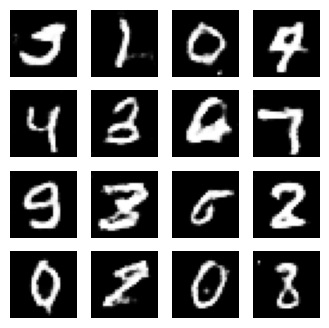

In [13]:
generator.load_weights("models/generator_weights")
discriminator.load_weights("models/discriminator_weights")
train(train_dataset, 25, 100) #up to 50 epochs

In [14]:
generator.save_weights("models/generator_weights")
discriminator.save_weights("models/discriminator_weights")

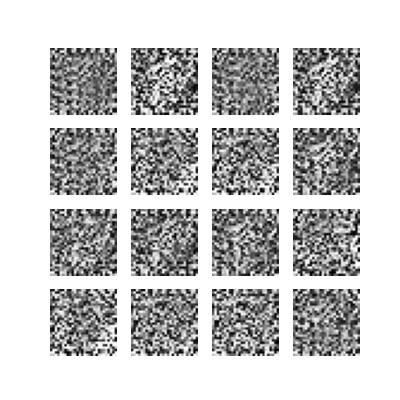

In [15]:
def display_image(epoch_no):
    return PIL.Image.open('images/image_at_epoch_{:04d}.png'.format(epoch_no))

display_image(EPOCHS)

In [24]:
import imageio
import os

anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    frames = ["images/" + f for f in os.listdir("images") if os.path.isfile(os.path.join("images", f))]

    for filename in sorted(frames):
        image = imageio.v2.imread(filename)
        writer.append_data(image)